In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import cv2
import matplotlib.cm as cm
import warnings
import shutil
from datetime import datetime

In [ ]:
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
LOCAL_PROJECT_DIR = '/content/drive/MyDrive/NIH_Chest_Xray'
NIH_DATA_PARENT_DIR = LOCAL_PROJECT_DIR
IMAGES_ROOT_DIR = os.path.join(NIH_DATA_PARENT_DIR, 'images', 'good')

LABELS_PATH_DRIVE = '/content/drive/MyDrive/NIH_Chest_Xray/Data_Entry_2017_v2020.csv'
BAD_LABELS_CSV_PATH_DRIVE = '/content/drive/MyDrive/NIH_Chest_Xray/cxr14_bad_labels.csv'
TRAIN_VAL_LIST_PATH_DRIVE = '/content/drive/MyDrive/NIH_Chest_Xray/train_val_list.txt'
TEST_LIST_PATH_DRIVE = '/content/drive/MyDrive/NIH_Chest_Xray/test_list.txt'
BBOX_LIST_PATH_DRIVE = '/content/BBox_List_2017.csv'


LABELS_PATH = os.path.join(NIH_DATA_PARENT_DIR, os.path.basename(LABELS_PATH_DRIVE))
BAD_LABELS_CSV_PATH = os.path.join(NIH_DATA_PARENT_DIR, os.path.basename(BAD_LABELS_CSV_PATH_DRIVE))
TRAIN_VAL_LIST_PATH = os.path.join(NIH_DATA_PARENT_DIR, os.path.basename(TRAIN_VAL_LIST_PATH_DRIVE))
TEST_LIST_PATH = os.path.join(NIH_DATA_PARENT_DIR, os.path.basename(TEST_LIST_PATH_DRIVE))
BBOX_LIST_PATH = os.path.join(NIH_DATA_PARENT_DIR, os.path.basename(BBOX_LIST_PATH_DRIVE))

In [ ]:
ALL_PATHOLOGIES = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
                     'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
                     'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
SELECTED_CONDITIONS = ALL_PATHOLOGIES

BBOX_CONDITIONS = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
                   'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# SELECTED_BACKBONE = "DenseNet121"
# SELECTED_BACKBONE = "ResNet50"
# SELECTED_BACKBONE = "EfficientNetB0"
SELECTED_BACKBONE = "MobileNetV2"

In [ ]:
def localize_colab_data():
    local_base_dir = NIH_DATA_PARENT_DIR
    if not os.path.exists(local_base_dir):
        os.makedirs(local_base_dir, exist_ok=True)
        print(f"Created local project directory: {local_base_dir}")

    global LABELS_PATH, BAD_LABELS_CSV_PATH, IMAGES_ROOT_DIR
    global TRAIN_VAL_LIST_PATH, TEST_LIST_PATH, BBOX_LIST_PATH

    local_images_path_base = os.path.join(local_base_dir, 'images', 'good')
    os.makedirs(local_images_path_base, exist_ok=True)
    IMAGES_ROOT_DIR = local_images_path_base

    LABELS_PATH = os.path.join(local_base_dir, os.path.basename(LABELS_PATH_DRIVE))
    BAD_LABELS_CSV_PATH = os.path.join(local_base_dir, os.path.basename(BAD_LABELS_CSV_PATH_DRIVE))
    TRAIN_VAL_LIST_PATH = os.path.join(local_base_dir, os.path.basename(TRAIN_VAL_LIST_PATH_DRIVE))
    TEST_LIST_PATH = os.path.join(local_base_dir, os.path.basename(TEST_LIST_PATH_DRIVE))
    BBOX_LIST_PATH = os.path.join(local_base_dir, os.path.basename(BBOX_LIST_PATH_DRIVE))

    files_to_copy = [
        (LABELS_PATH_DRIVE, LABELS_PATH),
        (BAD_LABELS_CSV_PATH_DRIVE, BAD_LABELS_CSV_PATH),
        (TRAIN_VAL_LIST_PATH_DRIVE, TRAIN_VAL_LIST_PATH),
        (TEST_LIST_PATH_DRIVE, TEST_LIST_PATH),
        (BBOX_LIST_PATH_DRIVE, BBOX_LIST_PATH)
    ]

    for drive_path, local_path in files_to_copy:
        if os.path.exists(drive_path):
            shutil.copy2(drive_path, local_path)
            print(f"Copied {os.path.basename(drive_path)} to {local_path}")

    DRIVE_IMAGES_PATH = '/content/drive/MyDrive/NIH_Chest_Xray/images/good'
    if os.path.exists(DRIVE_IMAGES_PATH):
        for i in range(1, 13):
            drive_subfolder = os.path.join(DRIVE_IMAGES_PATH, f"images_{i:03d}")
            local_subfolder_target = os.path.join(IMAGES_ROOT_DIR, f"images_{i:03d}")
            drive_actual_image_folder = os.path.join(drive_subfolder, "images")
            local_actual_image_folder_target = os.path.join(local_subfolder_target, "images")

            if os.path.exists(drive_actual_image_folder):
                os.makedirs(local_subfolder_target, exist_ok=True)
                if not os.path.exists(local_actual_image_folder_target):
                    print(f"Copying {drive_actual_image_folder} to {local_actual_image_folder_target}...")
                    shutil.copytree(drive_actual_image_folder, local_actual_image_folder_target)
                    print(f"Finished copying {os.path.basename(drive_actual_image_folder)}.")
        print("Image data localization process potentially completed.")

    print(f"Updated paths:")
    print(f"  IMAGES_ROOT_DIR: {IMAGES_ROOT_DIR}")
    print(f"  LABELS_PATH: {LABELS_PATH}")
    print(f"  TRAIN_VAL_LIST_PATH: {TRAIN_VAL_LIST_PATH}")
    print(f"  TEST_LIST_PATH: {TEST_LIST_PATH}")
    print(f"  BBOX_LIST_PATH: {BBOX_LIST_PATH}")

In [ ]:
def _locate_all_image_paths(images_root_dir_param):
    image_locations = {}
    print(f"Scanning for images under: {images_root_dir_param}")
    for i in range(1, 13):
        subfolder_name = f"images_{i:03d}"
        current_image_folder = os.path.join(images_root_dir_param, subfolder_name, "images")
        if os.path.isdir(current_image_folder):
            for img_name in os.listdir(current_image_folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_locations[img_name] = os.path.join(current_image_folder, img_name)
        else:
            print(f"Warning: Image subfolder not found: {current_image_folder}")
    print(f"Found {len(image_locations)} image paths.")
    if not image_locations:
        print(f"No images found.")
    return image_locations

In [ ]:
def analyze_class_distribution(df, dataset_name="Dataset"):
    if df.empty: print(f"Cannot analyze {dataset_name}: DataFrame is empty."); return
    class_counts = df[SELECTED_CONDITIONS].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title(f"Class Distribution in {dataset_name} ({len(SELECTED_CONDITIONS)} Pathologies)")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=75, ha="right")
    plt.tight_layout()
    plt.show()
    if len(SELECTED_CONDITIONS) > 1 and len(df) > 1:
        plt.figure(figsize=(12, 10))
        corr_matrix = df[SELECTED_CONDITIONS].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
        plt.title(f"Co-occurrence of Pathologies in {dataset_name}")
        plt.xticks(rotation=75, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

# Data Preprocessing and Augmentation

In [ ]:
data_augmentation_layers = tf.keras.Sequential([ 
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest'), 
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='nearest'), 
    tf.keras.layers.RandomZoom(height_factor=0.1, fill_mode='nearest'), 
    tf.keras.layers.RandomFlip(mode="horizontal"),
    ], 
    name="data_augmentation")

def load_and_preprocess_image(image_path, label): 
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
    img = img / 255.0
    return img, label

def augment_image_fn(image, label): 
    image = data_augmentation_layers(image, training=True)
    return image, label

def create_tf_dataset(dataframe, batch_size_param, shuffle=True, augment=False):
    if dataframe.empty: 
        return tf.data.Dataset.from_tensor_slices((tf.constant([],dtype=tf.string), tf.constant([], shape=(0, len(SELECTED_CONDITIONS)), dtype=tf.float32))).batch(batch_size_param)
    image_paths = dataframe['path'].values
    labels_df_values = dataframe[SELECTED_CONDITIONS].values.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels_df_values))

    if shuffle: 
        dataset = dataset.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if augment: 
        dataset = dataset.map(augment_image_fn, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(batch_size_param)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

def load_official_split_filenames(filepath):
    if not os.path.exists(filepath): 
        print(f"Warning: Split file not found at {filepath}"); 
        return []
    with open(filepath, 'r') as f: 
        filenames = [line.strip() for line in f if line.strip()]
        return filenames

In [ ]:
def preprocess_data(full_df, bbox_data_df):
    train_val_filenames = load_official_split_filenames(TRAIN_VAL_LIST_PATH)
    test_filenames = load_official_split_filenames(TEST_LIST_PATH)

    print(f"Loaded {len(train_val_filenames)} train/val filenames and {len(test_filenames)} test filenames.")

    official_train_val_df = full_df[full_df['Image Index'].isin(train_val_filenames)].copy()
    official_test_df = full_df[full_df['Image Index'].isin(test_filenames)].copy()

    print(f"Matched {len(official_train_val_df)} train/val images and {len(official_test_df)} test images.")

    if len(official_train_val_df) > 1:
        train_df, valid_df = train_test_split(official_train_val_df, test_size=0.20, random_state=42)
    else:
        train_df = official_train_val_df; valid_df = pd.DataFrame(columns=official_train_val_df.columns)

    print(f"Official Training set size: {len(train_df)}")
    print(f"Official Validation set size: {len(valid_df)}")
    print(f"Official Test set size: {len(official_test_df)}")

    if bbox_data_df is not None and not official_test_df.empty:
        images_with_bboxes = bbox_data_df['Image Index'].unique()
        official_test_df['has_bbox'] = official_test_df['Image Index'].isin(images_with_bboxes)

    if not train_df.empty: analyze_class_distribution(train_df, "Official Training Set")
    if not valid_df.empty: analyze_class_distribution(valid_df, "Official Validation Set")
    if not official_test_df.empty: analyze_class_distribution(official_test_df, "Official Test Set")

    train_generator = create_tf_dataset(train_df, BATCH_SIZE, shuffle=True, augment=True)
    valid_generator = create_tf_dataset(valid_df, BATCH_SIZE, shuffle=False, augment=False)
    test_generator = create_tf_dataset(official_test_df, BATCH_SIZE, shuffle=False, augment=False)

    return train_generator, valid_generator, test_generator, train_df, valid_df, official_test_df

# 3. Class Weights and Weighted Loss

In [ ]:
def calculate_positive_class_weights(train_df_labels_param):
    weights = []
    num_samples = len(train_df_labels_param)
    for cond in SELECTED_CONDITIONS:
        pos = train_df_labels_param[cond].sum()
        neg = num_samples - pos
        weight = neg / pos if pos > 0 and neg > 0 else 1.0
        weights.append(weight)
    return np.array(weights)

def get_weighted_binary_crossentropy(pos_weights_param, label_smoothing=0.01):
    pos_weights_tensor = tf.constant(pos_weights_param, dtype=tf.float32)
    epsilon = tf.keras.backend.epsilon()
    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        if label_smoothing > 0:
            y_true = y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing

        y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        logits_pred = tf.math.log(y_pred_clipped / (1.0 - y_pred_clipped))
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels=y_true,
            logits=logits_pred,
            pos_weight=pos_weights_tensor
        )
        return tf.reduce_mean(loss)
    return weighted_binary_crossentropy

# 4. Model Building

In [ ]:
def build_model(image_size_param, num_classes_param, loss_function_param, backbone_name="DenseNet121"):
    input_shape_model = (image_size_param[0], image_size_param[1], 3)

    if backbone_name == "DenseNet121":
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape_model)
    elif backbone_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_model)
    elif backbone_name == "EfficientNetB0":
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape_model)
    elif backbone_name == "MobileNetV2":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape_model)

    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    predictions = Dense(num_classes_param, activation='sigmoid', name='predictions')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=loss_function_param,
                  metrics=['binary_accuracy',
                           tf.keras.metrics.AUC(name='auc_roc', multi_label=True, num_labels=num_classes_param, curve='ROC'),
                           tf.keras.metrics.AUC(name='auc_pr', multi_label=True, num_labels=num_classes_param, curve='PR')])
    return model, base_model

# 5. Model Training

In [ ]:
def train_model(model, train_gen, valid_gen, train_len, valid_len, epochs=25):
    valid_gen = None if valid_len==0 else valid_gen

    train_steps = (train_len+BATCH_SIZE-1)//BATCH_SIZE
    valid_steps = (valid_len+BATCH_SIZE-1)//BATCH_SIZE if valid_len > 0 else 0

    callbacks = [ 
        ModelCheckpoint('best_model_initial.weights.h5', monitor='val_auc_roc', verbose=1, save_best_only=True, mode='max', save_weights_only=True), 
        EarlyStopping(monitor='val_auc_roc', patience=7, verbose=1, mode='max', restore_best_weights=True), 
        ReduceLROnPlateau(monitor='val_auc_roc', factor=0.2, patience=3, verbose=1, mode='max', min_lr=1e-6) 
    ]

    history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=epochs, validation_data=valid_gen, validation_steps=valid_steps, callbacks=callbacks, verbose=1)
    
    return history

def fine_tune_model(model, base_model, train_gen, valid_gen, train_len, valid_len, loss_fn, epochs=15):
    valid_gen = None if valid_len==0 else valid_gen
    fine_tune_at = 20
    if len(base_model.layers)>fine_tune_at:
        for layer in base_model.layers[-fine_tune_at:]: 
            layer.trainable=True # Unfreeze last layers
            
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=loss_fn, metrics=[
        'binary_accuracy', 
        tf.keras.metrics.AUC(name='auc_roc', multi_label=True, num_labels=len(SELECTED_CONDITIONS), curve='ROC'), 
        tf.keras.metrics.AUC(name='auc_pr', multi_label=True, num_labels=len(SELECTED_CONDITIONS), curve='PR')])
    
    train_steps=(train_len+BATCH_SIZE-1)//BATCH_SIZE
    valid_steps=(valid_len+BATCH_SIZE-1)//BATCH_SIZE if valid_len > 0 else 0

    callbacks_ft = [ 
        ModelCheckpoint('best_model_finetuned.weights.h5', monitor='val_auc_roc', verbose=1, save_best_only=True, mode='max', save_weights_only=True), 
        EarlyStopping(monitor='val_auc_roc', patience=10, verbose=1, mode='max', restore_best_weights=True), 
        ReduceLROnPlateau(monitor='val_auc_roc', factor=0.2, patience=5, verbose=1, mode='max', min_lr=1e-7) ]
    
    history_ft = model.fit(train_gen, steps_per_epoch=train_steps, epochs=epochs, validation_data=valid_gen, validation_steps=valid_steps, callbacks=callbacks_ft, verbose=1)
    return history_ft

# 6. Plot Training History

In [ ]:
def plot_training_history(history, history_ft=None):
    metrics_to_plot = ['loss', 'binary_accuracy', 'auc_roc', 'auc_pr']

    for metric_base_name in metrics_to_plot:
        plt.figure(figsize=(10, 6)) 

        train_metric_key = metric_base_name
        val_metric_key = f'val_{metric_base_name}'

        epochs_initial_train = []
        epochs_initial_val = []

        if train_metric_key in history.history:
            epochs_initial_train = range(1, len(history.history[train_metric_key]) + 1)
            plt.plot(epochs_initial_train, history.history[train_metric_key], 'o-', label=f'Train {metric_base_name.replace("_", " ").title()}')

        if val_metric_key in history.history:
            epochs_initial_val = range(1, len(history.history[val_metric_key]) + 1)
            if epochs_initial_val: 
                 plt.plot(epochs_initial_val, history.history[val_metric_key], 's-', label=f'Validation {metric_base_name.replace("_", " ").title()}')

        last_epoch_initial = 0
        if epochs_initial_train:
            last_epoch_initial = epochs_initial_train[-1]
        elif epochs_initial_val:
            last_epoch_initial = epochs_initial_val[-1]

        if history_ft:
            epochs_ft_train = []
            epochs_ft_val = []

            if train_metric_key in history_ft.history:
                epochs_ft_train = range(last_epoch_initial + 1, last_epoch_initial + 1 + len(history_ft.history[train_metric_key]))
                plt.plot(epochs_ft_train, history_ft.history[train_metric_key], 'o--', label=f'Fine-tune Train {metric_base_name.replace("_", " ").title()}')

            if val_metric_key in history_ft.history:
                epochs_ft_val = range(last_epoch_initial + 1, last_epoch_initial + 1 + len(history_ft.history[val_metric_key]))
                if epochs_ft_val:
                    plt.plot(epochs_ft_val, history_ft.history[val_metric_key], 's--', label=f'Fine-tune Validation {metric_base_name.replace("_", " ").title()}')

        plt.title(f'Model {metric_base_name.replace("_", " ").title()} Over Epochs')
        plt.ylabel(metric_base_name.replace("_", " ").title())
        plt.xlabel('Epoch')
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# 7. Model Evaluation

In [ ]:
def evaluate_model(model, test_generator, test_df):
    steps = (len(test_df)+BATCH_SIZE-1)//BATCH_SIZE
    print(f"Evaluating classification on {len(test_df)} test samples ({steps} steps).");

    y_pred_prob = model.predict(test_generator, steps=steps, verbose=1)
    y_true = test_df[SELECTED_CONDITIONS].values[:len(y_pred_prob)]

    print("\n--- ROC AUC Scores per Class ---")
    auc_scores = []
    for i, name in enumerate(SELECTED_CONDITIONS):
        try:
            if len(np.unique(y_true[:, i])) > 1: 
                auc_val = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
                auc_scores.append(auc_val)
                print(f"  {name}: {auc_val:.4f}")
            else: print(f"  {name}: N/A (1 class in y_true)"); auc_scores.append(np.nan)
        except ValueError as e: 
            print(f"  AUC Error for {name}: {e}")
            auc_scores.append(np.nan)
    avg_auc = np.nanmean(auc_scores)
    print(f"Avg ROC AUC (ignoring NaNs): {avg_auc:.4f}")

    thresh=0.5
    y_pred_bin = (y_pred_prob >= thresh).astype(int)

    print(f"\n--- Class Reports (thresh={thresh}) ---")
    for i, name in enumerate(SELECTED_CONDITIONS):
        print(f"\n{name}:")
        if len(y_true[:,i]) > 0: 
            print(confusion_matrix(y_true[:, i], y_pred_bin[:, i]))
            print(classification_report(y_true[:, i], y_pred_bin[:, i], zero_division=0, target_names=[f'No {name}', name]))
        else: print("No samples in y_true.")
    return y_true, y_pred_prob, y_pred_bin

# 8. Explainability and Localization

In [ ]:
def get_gradcam_target_layer_name(model):
    preferred = ['_concat', '_relu', '_bn', '_activation'];
    for layer in reversed(model.layers):
        if 'conv5_block' in layer.name and any(layer.name.endswith(s) for s in preferred):
            if 'concat' in layer.name: 
                return layer.name
            if any(s in layer.name for s in ['_relu', '_bn']) and 'conv5_block' in layer.name: 
                return layer.name
    for layer in reversed(model.layers):
        if 'conv' in layer.name.lower() and len(layer.output_shape) == 4: 
            return layer.name
    if model.get_layer('relu'): 
        return 'relu'
    raise ValueError("Failed to find Grad-CAM layer.")

In [ ]:
def grad_cam(model, img_array, class_idx, layer_name=None):
    if layer_name is None: 
        layer_name = get_gradcam_target_layer_name(model)
    try: 
        target_layer = model.get_layer(layer_name)
    except ValueError: 
        layer_name = get_gradcam_target_layer_name(model)
        target_layer = model.get_layer(layer_name)

    grad_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])

    with tf.GradientTape() as tape:
        img_cast = tf.cast(img_array, tf.float32)
        conv_out, preds = grad_model(img_cast)
        if not (0 <= class_idx < preds.shape[1]): 
            class_idx = 0
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)

    if grads is None: 
        print(f"Warn: Grad-CAM grads None for class {class_idx}.")
        return np.zeros((IMG_SIZE[0]//16, IMG_SIZE[1]//16)) # Smaller default
    
    grads_img = grads[0]
    conv_out_img = conv_out[0]
    weights = tf.reduce_mean(grads_img, axis=(0, 1))
    cam_output = tf.reduce_sum(tf.multiply(conv_out_img, weights), axis=-1)
    cam_output = tf.maximum(cam_output, 0)
    max_val = tf.reduce_max(cam_output)
    if max_val > 0: cam_output = cam_output / max_val
    
    return cam_output.numpy()

def overlay_gradcam(img_rgb, heatmap, alpha=0.5):
    if img_rgb is None or heatmap is None: 
        return None
    img_resized = cv2.resize(img_rgb, IMG_SIZE) if img_rgb.shape[:2] != IMG_SIZE else img_rgb.copy()

    heatmap_resized = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    if img_resized.dtype != np.uint8: 
        img_uint8 = (img_resized * 255).astype(np.uint8) if np.max(img_resized)<=1.0 else img_resized.astype(np.uint8)
    else: 
        img_uint8 = img_resized
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img_uint8, 1 - alpha, heatmap_color_rgb, alpha, 0)
    return overlay

In [ ]:
def generate_bbox_from_heatmap(heatmap, threshold_ratio=0.2):
    if heatmap is None or np.max(heatmap) == 0:
        return None

    threshold_value = np.max(heatmap) * threshold_ratio
    binary_mask = (heatmap >= threshold_value).astype(np.uint8)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    return x, y, w, h

In [ ]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0.0

    return iou

In [ ]:
def visualize_explanations(model_to_explain, df_for_viz, bbox_data_df, class_names_list_param, num_samples_viz=1, grad_cam_target_layer=None, heatmap_threshold=0.2):
    classes_to_visualize = [c for c in BBOX_CONDITIONS if c in class_names_list_param][:min(len(BBOX_CONDITIONS), 3)]
    if not classes_to_visualize:
         classes_to_visualize = class_names_list_param[:min(len(class_names_list_param), 3)]
    print(f"Generating Grad-CAM & BBox for conditions: {', '.join(classes_to_visualize)}")

    if df_for_viz.empty: print("DataFrame for Grad-CAM empty. Skipping."); return
    ORIGINAL_IMG_SIZE = (1024, 1024)
    for condition_name_viz in classes_to_visualize:
        class_idx_val = class_names_list_param.index(condition_name_viz)

        samples_to_consider = df_for_viz[df_for_viz[condition_name_viz] == 1]
        if bbox_data_df is not None:
            imgs_with_gt_bbox_for_cond = bbox_data_df[bbox_data_df['Finding_Label_BBox'] == condition_name_viz]['Image Index'].unique()
            positive_samples_with_gt_bbox = samples_to_consider[samples_to_consider['Image Index'].isin(imgs_with_gt_bbox_for_cond)]
            if not positive_samples_with_gt_bbox.empty:
                 selected_samples_df = positive_samples_with_gt_bbox.sample(min(num_samples_viz, len(positive_samples_with_gt_bbox)), random_state=42) # Use loop var for different samples
            else:
                 selected_samples_df = samples_to_consider.sample(min(num_samples_viz, len(samples_to_consider)), random_state=42+1)
        else: 
             selected_samples_df = samples_to_consider.sample(min(num_samples_viz, len(samples_to_consider)), random_state=42+2)

        if selected_samples_df.empty:
             print(f"No suitable samples found for {condition_name_viz} for Grad-CAM/BBox visualization."); continue

        actual_num_samples_viz = len(selected_samples_df)

        plt.figure(figsize=(20, 7 * actual_num_samples_viz))
        for i, (idx, row) in enumerate(selected_samples_df.iterrows()):
            img_path_viz = row['path']
            img_index_viz = row['Image Index']

            if not os.path.exists(img_path_viz): print(f"Img not found: {img_path_viz}"); continue
            original_img_bgr = cv2.imread(img_path_viz);
            if original_img_bgr is None: print(f"Cannot read: {img_path_viz}"); continue
            original_img_rgb = cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2RGB)

            #Model Input & Prediction
            resized_img_for_model = cv2.resize(original_img_rgb, IMG_SIZE) # Resize for model
            img_array_for_model = np.expand_dims(resized_img_for_model.astype(np.float32) / 255.0, axis=0)
            predictions_viz = model_to_explain.predict(img_array_for_model, verbose=0)[0]
            predicted_prob_viz = predictions_viz[class_idx_val]

            # Grad-CAM
            cam_heatmap_viz = grad_cam(model_to_explain, img_array_for_model, class_idx_val, layer_name=grad_cam_target_layer)
            if cam_heatmap_viz is None: print(f"Grad-CAM None for {img_path_viz}"); continue
            superimposed_img_viz = overlay_gradcam(resized_img_for_model, cam_heatmap_viz, alpha=0.4) # Overlay on resized image
            if superimposed_img_viz is None: print(f"Overlay failed for {img_path_viz}"); continue

            # Predicted BBox from Heatmap
            pred_bbox_coords_heatmap = generate_bbox_from_heatmap(cam_heatmap_viz, threshold_ratio=heatmap_threshold)
            pred_bbox_scaled = None
            if pred_bbox_coords_heatmap:
                h_h, w_h = cam_heatmap_viz.shape
                h_img, w_img = IMG_SIZE
                x_p, y_p, w_p, h_p = pred_bbox_coords_heatmap
                x_p_scaled = int((x_p / w_h) * w_img)
                y_p_scaled = int((y_p / h_h) * h_img)
                w_p_scaled = int((w_p / w_h) * w_img)
                h_p_scaled = int((h_p / h_h) * h_img)
                pred_bbox_scaled = (x_p_scaled, y_p_scaled, w_p_scaled, h_p_scaled)


            # Ground Truth BBox
            gt_bboxes_for_img_cond = []
            if bbox_data_df is not None:
                 gt_bboxes_for_img_cond = bbox_data_df[(bbox_data_df['Image Index'] == img_index_viz) & (bbox_data_df['Finding_Label_BBox'] == condition_name_viz)].to_dict('records')

            ax3 = plt.subplot(actual_num_samples_viz, 4, i * 4 + 3)
            plt.imshow(superimposed_img_viz); plt.title(f"Overlay (Pred: {predicted_prob_viz:.2f})"); plt.axis('off')
            if pred_bbox_scaled:
                rect = patches.Rectangle((pred_bbox_scaled[0], pred_bbox_scaled[1]), pred_bbox_scaled[2], pred_bbox_scaled[3],
                                         linewidth=2, edgecolor='lime', facecolor='none')
                ax3.add_patch(rect)

            ax4 = plt.subplot(actual_num_samples_viz, 4, i * 4 + 4)
            plt.imshow(resized_img_for_model)
            plt.title(f"GT & Pred BBox\n(IoU: Calculating...)") 
            plt.axis('off')
            iou_val = 0.0 # Default

            if gt_bboxes_for_img_cond:
                for gt_bbox in gt_bboxes_for_img_cond:
                    x_gt = int((gt_bbox['Bbox_x'] / ORIGINAL_IMG_SIZE[0]) * IMG_SIZE[0])
                    y_gt = int((gt_bbox['Bbox_y'] / ORIGINAL_IMG_SIZE[1]) * IMG_SIZE[1])
                    w_gt = int((gt_bbox['Bbox_w'] / ORIGINAL_IMG_SIZE[0]) * IMG_SIZE[0])
                    h_gt = int((gt_bbox['Bbox_h'] / ORIGINAL_IMG_SIZE[1]) * IMG_SIZE[1])
                    gt_rect = patches.Rectangle((x_gt, y_gt), w_gt, h_gt,
                                                linewidth=2, edgecolor='red', facecolor='none') # Red for GT
                    ax4.add_patch(gt_rect)

                    if pred_bbox_scaled:
                         pred_box_iou_fmt = (pred_bbox_scaled[0], pred_bbox_scaled[1],
                                             pred_bbox_scaled[0] + pred_bbox_scaled[2], pred_bbox_scaled[1] + pred_bbox_scaled[3])
                         gt_box_iou_fmt = (x_gt, y_gt, x_gt + w_gt, y_gt + h_gt)
                         iou_val = calculate_iou(pred_box_iou_fmt, gt_box_iou_fmt)
                         if gt_bbox == gt_bboxes_for_img_cond[0]:
                              ax4.set_title(f"GT(red) & Pred(lime) BBox\n(IoU: {iou_val:.2f})")


            if pred_bbox_scaled:
                pred_rect = patches.Rectangle((pred_bbox_scaled[0], pred_bbox_scaled[1]), pred_bbox_scaled[2], pred_bbox_scaled[3],
                                         linewidth=2, edgecolor='lime', facecolor='none')
                ax4.add_patch(pred_rect)


        plt.suptitle(f"Grad-CAM and BBox Localization for {condition_name_viz}", fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

In [ ]:
def grad_cam(model, img_array, class_idx, layer_name=None):
    if layer_name is None: 
        layer_name = get_gradcam_target_layer_name(model)
    try: 
        target_layer = model.get_layer(layer_name)
    except ValueError: 
        layer_name = get_gradcam_target_layer_name(model)
        target_layer = model.get_layer(layer_name)

    grad_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])

    with tf.GradientTape() as tape:
        img_cast = tf.cast(img_array, tf.float32)
        conv_out, preds = grad_model(img_cast)
        if not (0 <= class_idx < preds.shape[1]): 
            class_idx = 0
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)

    if grads is None: 
        print(f"Warn: Grad-CAM grads None for class {class_idx}.")
        return np.zeros((IMG_SIZE[0]//16, IMG_SIZE[1]//16)) # Smaller default
    
    grads_img = grads[0]
    conv_out_img = conv_out[0]
    weights = tf.reduce_mean(grads_img, axis=(0, 1))
    cam_output = tf.reduce_sum(tf.multiply(conv_out_img, weights), axis=-1)
    cam_output = tf.maximum(cam_output, 0)
    max_val = tf.reduce_max(cam_output)
    if max_val > 0: cam_output = cam_output / max_val
    
    return cam_output.numpy()

def overlay_gradcam(img_rgb, heatmap, alpha=0.5):
    if img_rgb is None or heatmap is None: 
        return None
    img_resized = cv2.resize(img_rgb, IMG_SIZE) if img_rgb.shape[:2] != IMG_SIZE else img_rgb.copy()

    heatmap_resized = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    if img_resized.dtype != np.uint8: 
        img_uint8 = (img_resized * 255).astype(np.uint8) if np.max(img_resized)<=1.0 else img_resized.astype(np.uint8)
    else: 
        img_uint8 = img_resized
    heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img_uint8, 1 - alpha, heatmap_color_rgb, alpha, 0)
    return overlay

In [ ]:
def generate_heatmap_from_grads_and_features(grads_for_image_class, features_for_image):
    # grads_for_image_class shape: (H_feat, W_feat, C_feat)
    # features_for_image shape: (H_feat, W_feat, C_feat)
    weights = tf.reduce_mean(grads_for_image_class, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(features_for_image, weights), axis=-1)
    cam = tf.maximum(cam, 0) # ReLU
    max_val = tf.reduce_max(cam)
    if max_val > 0:
        cam = cam / max_val
    return cam.numpy()

In [ ]:
def evaluate_localization(model, test_df, bbox_data_df, class_names_list_param, heatmap_threshold=0.2, iou_threshold=0.1):
    print("\n--- Evaluating Localization Performance ---")
    if bbox_data_df is None or test_df.empty:
        print("BBox data or test_df empty. Skipping localization evaluation.")
        return None

    test_images_with_gt_bboxes_indices = test_df[test_df['has_bbox'] == True]['Image Index'].unique()
    if len(test_images_with_gt_bboxes_indices) == 0:
        print("No test images with GT bboxes. Skipping localization evaluation.")
        return None

    localization_results = {cond: {'ious': [], 'correct_iou': 0, 'total_preds': 0, 'total_gt': 0} for cond in BBOX_CONDITIONS}
    ORIGINAL_IMG_SIZE = (1024, 1024)

    last_conv_layer_name = get_gradcam_target_layer_name(model)
    target_conv_layer = model.get_layer(last_conv_layer_name)

    feature_extractor_model = Model(inputs=model.inputs, outputs=target_conv_layer.output)
    classifier_input_shape = target_conv_layer.output.shape[1:]
    classifier_input = tf.keras.Input(shape=classifier_input_shape, name="classifier_model_input")
    x_clf = classifier_input
    found_target_layer_in_orig_model = False
    for layer in model.layers:
        if layer.name == last_conv_layer_name:
            found_target_layer_in_orig_model = True
            continue
        if found_target_layer_in_orig_model:
            x_clf = layer(x_clf)
    classifier_model = Model(inputs=classifier_input, outputs=x_clf, name="classifier_from_features")

    test_df_with_bboxes = test_df[test_df['Image Index'].isin(test_images_with_gt_bboxes_indices)].copy()

    inference_batch_size = max(1, BATCH_SIZE // 2)

    for batch_start in range(0, len(test_df_with_bboxes), inference_batch_size):
        batch_df = test_df_with_bboxes.iloc[batch_start : batch_start + inference_batch_size]
        if batch_df.empty: continue

        batch_img_arrays_for_model = []
        valid_rows_in_batch_info = []

        for i_row, row_content in batch_df.iterrows():
            img_path = row_content['path']
            if not os.path.exists(img_path):
                continue
            original_img_bgr = cv2.imread(img_path)
            if original_img_bgr is None:
                continue

            original_img_rgb = cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2RGB)
            resized_img = cv2.resize(original_img_rgb, IMG_SIZE)
            img_array_np = resized_img.astype(np.float32) / 255.0
            batch_img_arrays_for_model.append(img_array_np)
            valid_rows_in_batch_info.append(row_content)

        if not batch_img_arrays_for_model:
            continue

        batch_input_tensor_np = np.stack(batch_img_arrays_for_model, axis=0)
        batch_input_tensor = tf.convert_to_tensor(batch_input_tensor_np, dtype=tf.float32)

        batch_conv_outputs_tf = feature_extractor_model(batch_input_tensor, training=False) 

        for i_in_batch in range(batch_conv_outputs_tf.shape[0]):
            current_img_conv_outputs = batch_conv_outputs_tf[i_in_batch:i_in_batch+1]
            current_img_row = valid_rows_in_batch_info[i_in_batch]
            img_index = current_img_row['Image Index']

            gt_bboxes_all_conds_for_img = bbox_data_df[bbox_data_df['Image Index'] == img_index].to_dict('records')

            for condition_name in BBOX_CONDITIONS:
                if condition_name not in class_names_list_param: continue
                class_idx = class_names_list_param.index(condition_name)

                gt_bboxes_this_cond = [b for b in gt_bboxes_all_conds_for_img if b['Finding_Label_BBox'] == condition_name]
                localization_results[condition_name]['total_gt'] += len(gt_bboxes_this_cond)

                with tf.GradientTape() as tape:
                    tape.watch(current_img_conv_outputs)
                    predictions_from_conv = classifier_model(current_img_conv_outputs, training=False) 
                    class_score = predictions_from_conv[0, class_idx]

                grads_val = tape.gradient(class_score, current_img_conv_outputs)

                heatmap = np.zeros((IMG_SIZE[0]//16, IMG_SIZE[1]//16))
                if grads_val is not None:
                    heatmap = generate_heatmap_from_grads_and_features(grads_val[0], current_img_conv_outputs[0])

                pred_bbox_heatmap = generate_bbox_from_heatmap(heatmap, threshold_ratio=heatmap_threshold)

                if pred_bbox_heatmap:
                    localization_results[condition_name]['total_preds'] += 1
                    h_h, w_h = heatmap.shape; h_img, w_img = IMG_SIZE
                    x_p, y_p, w_p, h_p = pred_bbox_heatmap
                    x_p_s = int((x_p / w_h) * w_img); y_p_s = int((y_p / h_h) * h_img)
                    w_p_s = int((w_p / w_h) * w_img); h_p_s = int((h_p / h_h) * h_img)
                    pred_box_iou_fmt = (x_p_s, y_p_s, x_p_s + w_p_s, y_p_s + h_p_s)
                    max_iou_for_pred = 0.0
                    if gt_bboxes_this_cond:
                        for gt_bbox in gt_bboxes_this_cond:
                            x_gt = int((gt_bbox['Bbox_x'] / ORIGINAL_IMG_SIZE[0]) * IMG_SIZE[0])
                            y_gt = int((gt_bbox['Bbox_y'] / ORIGINAL_IMG_SIZE[1]) * IMG_SIZE[1])
                            w_gt = int((gt_bbox['Bbox_w'] / ORIGINAL_IMG_SIZE[0]) * IMG_SIZE[0])
                            h_gt = int((gt_bbox['Bbox_h'] / ORIGINAL_IMG_SIZE[1]) * IMG_SIZE[1])
                            gt_box_iou_fmt = (x_gt, y_gt, x_gt + w_gt, y_gt + h_gt)
                            iou = calculate_iou(pred_box_iou_fmt, gt_box_iou_fmt)
                            localization_results[condition_name]['ious'].append(iou)
                            max_iou_for_pred = max(max_iou_for_pred, iou)
                        if max_iou_for_pred >= iou_threshold:
                            localization_results[condition_name]['correct_iou'] += 1
                    else:
                        localization_results[condition_name]['ious'].append(0.0)


    print(f"\nLocalization Summary (IoU Threshold = {iou_threshold}):")
    avg_ious_all = []
    loc_accuracy_all = []
    for condition_name_eval in BBOX_CONDITIONS:
        res = localization_results[condition_name_eval]
        avg_iou = np.mean(res['ious']) if res['ious'] else 0.0
        loc_accuracy = (res['correct_iou'] / res['total_preds']) * 100 if res['total_preds'] > 0 else 0.0
        loc_recall = (res['correct_iou'] / res['total_gt']) * 100 if res['total_gt'] > 0 else 0.0

        print(f"  {condition_name_eval}:")
        print(f"    Avg IoU = {avg_iou:.3f} (over {len(res['ious'])} preds with GT match attempt)")
        print(f"    Localization Accuracy (Correct Preds / Total Preds) = {loc_accuracy:.2f}% ({res['correct_iou']}/{res['total_preds']})")
        print(f"    Localization Recall (Correct Preds / Total GT) = {loc_recall:.2f}% ({res['correct_iou']}/{res['total_gt']})")

        if res['ious']: avg_ious_all.extend(res['ious'])
        if res['total_preds'] > 0 : loc_accuracy_all.append(loc_accuracy)

    overall_avg_iou = np.mean(avg_ious_all) if avg_ious_all else 0.0
    overall_loc_accuracy = np.mean(loc_accuracy_all) if loc_accuracy_all else 0.0
    total_all_correct_iou = sum(localization_results[c]['correct_iou'] for c in BBOX_CONDITIONS)
    total_all_preds_made = sum(localization_results[c]['total_preds'] for c in BBOX_CONDITIONS)
    micro_avg_loc_accuracy = (total_all_correct_iou / total_all_preds_made) * 100 if total_all_preds_made > 0 else 0.0

    print("\n  Overall:")
    print(f"    Average IoU across all conditions/predictions (macro avg): {overall_avg_iou:.3f}")
    print(f"    Average Localization Accuracy (macro avg of per-class accuracies): {overall_loc_accuracy:.2f}%")
    print(f"    Overall Localization Accuracy (micro avg - total correct / total preds): {micro_avg_loc_accuracy:.2f}%")
    return localization_results

XAI Chest X-ray - 14 Pathologies, Official Split, Weighted Loss, BBox Localization
Using Backbone: MobileNetV2

--- 0. Configuring Data Paths & Potentially Localizing ---
Final effective paths being used:
  IMAGES_ROOT_DIR: /content/drive/MyDrive/NIH_Chest_Xray/images/good
  LABELS_PATH: /content/drive/MyDrive/NIH_Chest_Xray/Data_Entry_2017_v2020.csv
  TRAIN_VAL_LIST_PATH: /content/drive/MyDrive/NIH_Chest_Xray/train_val_list.txt
  TEST_LIST_PATH: /content/drive/MyDrive/NIH_Chest_Xray/test_list.txt
  BBOX_LIST_PATH: content/BBox_List_2017.csv
  SAVED_MODELS_DIR: /content/drive/MyDrive/NIH_Chest_Xray/saved_models_final

--- 1. Loading Data ---
Initial records from Data_Entry_2017_v2020.csv: 112120
Removed 257 images based on cxr14_bad_labels.csv.
Temporarily removed 60190 images with 'No Finding' label for pathology analysis.
Scanning for images under: /content/drive/MyDrive/NIH_Chest_Xray/images/good
Found 112120 image paths.
Total images processed for model input pipeline: 51673
Boundi

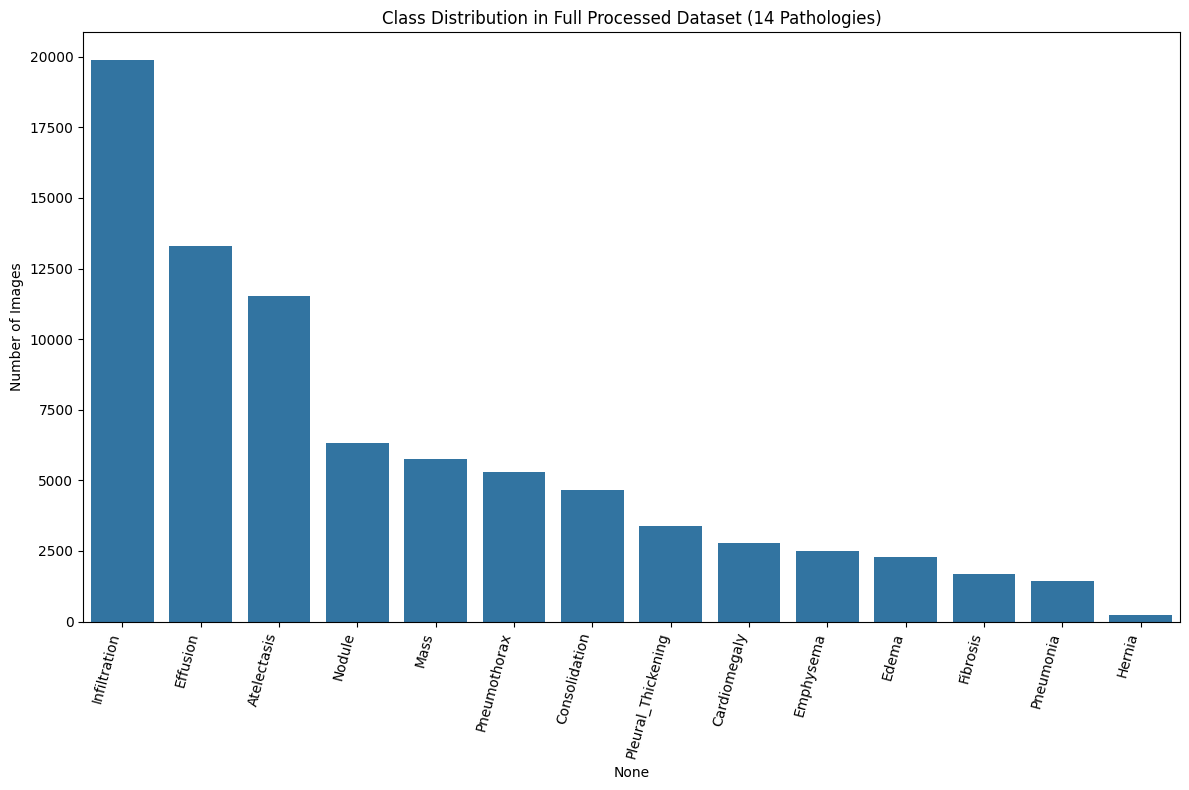

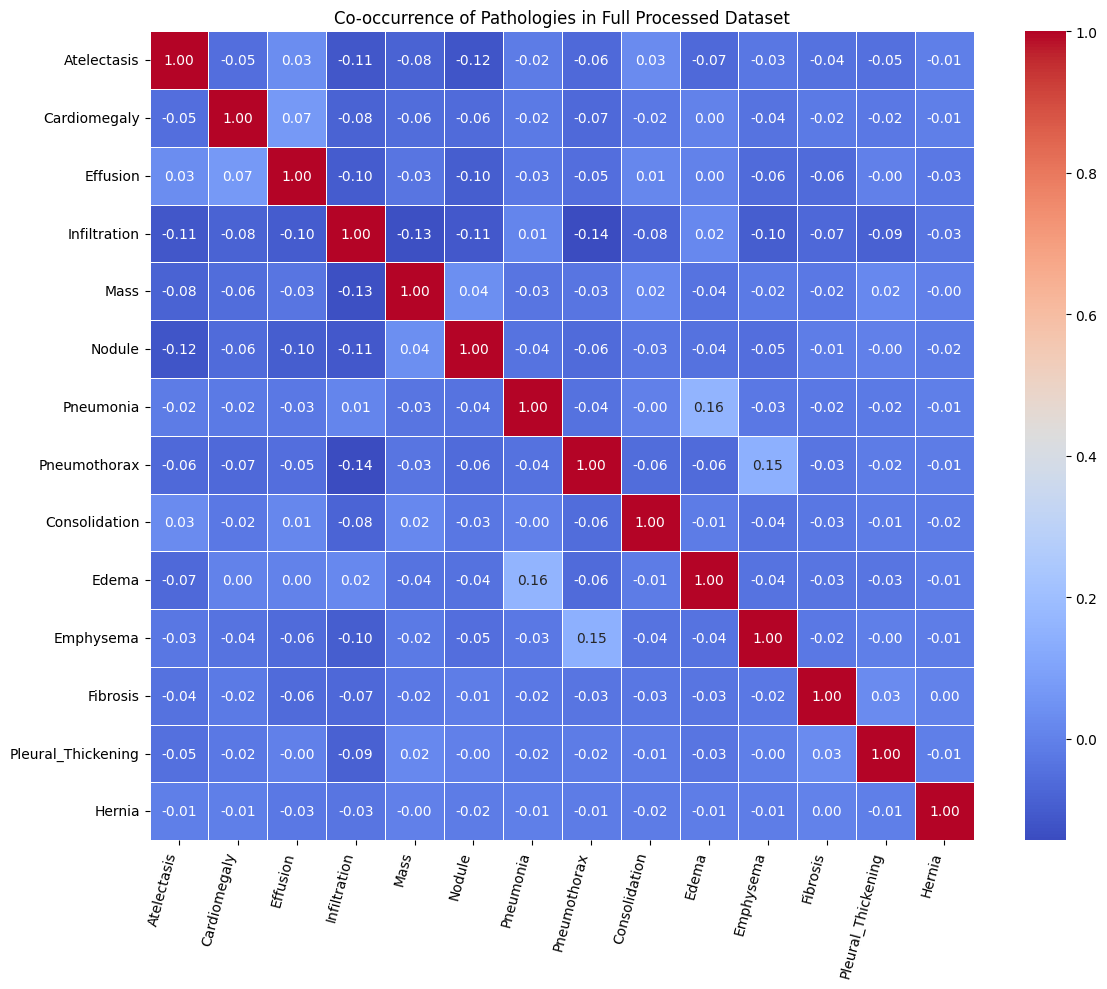

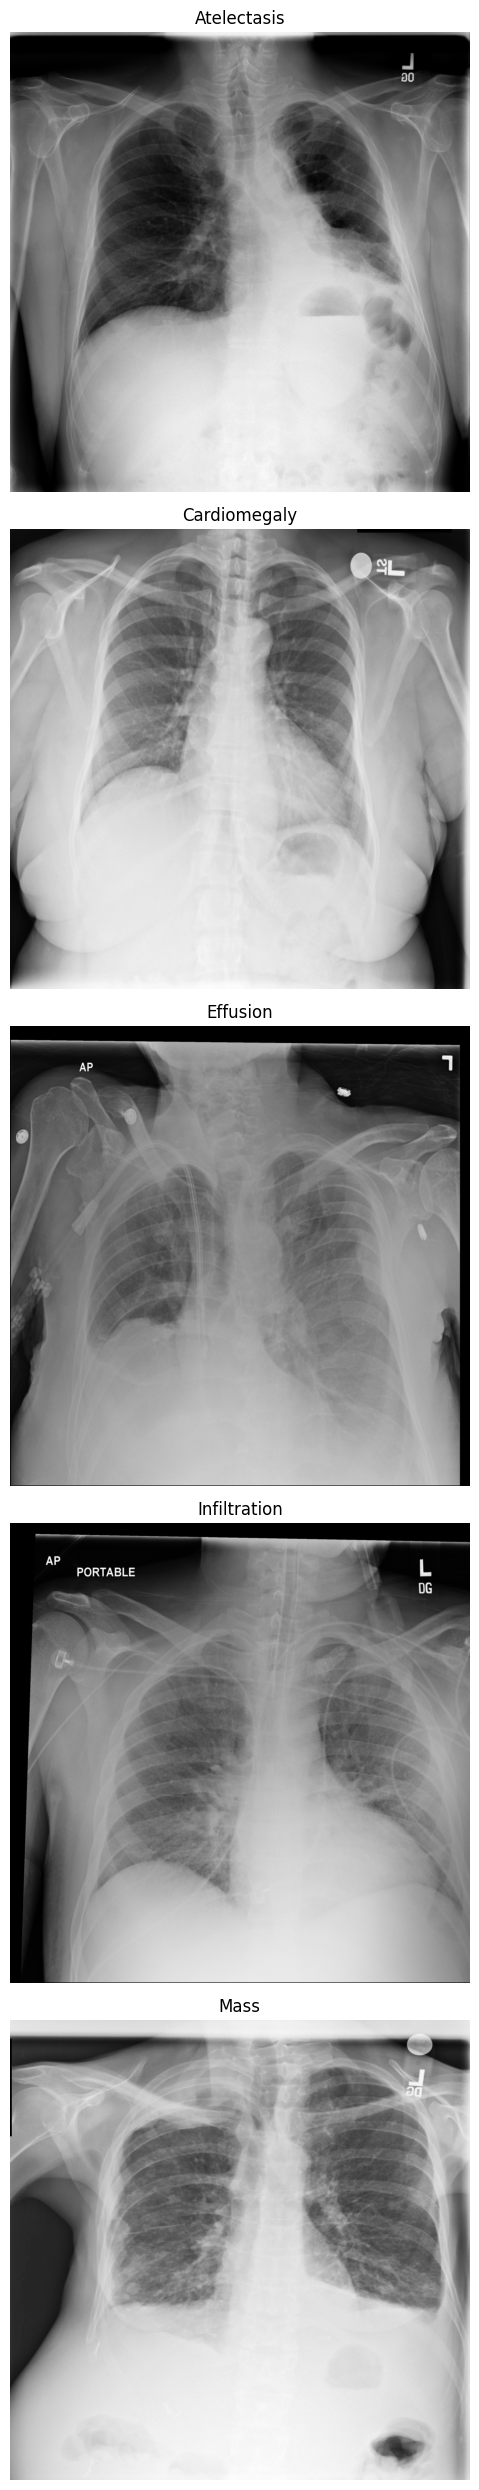


--- 2. Preprocessing & Official Split ---
Loaded 86524 train/val filenames and 25596 test filenames.
Matched 35969 train/val images and 15704 test images from loaded filenames.
Official Training set size: 28775
Official Validation set size: 7194
Official Test set size: 15704
No BBox data loaded, 'has_bbox' flag set to False for all test images.


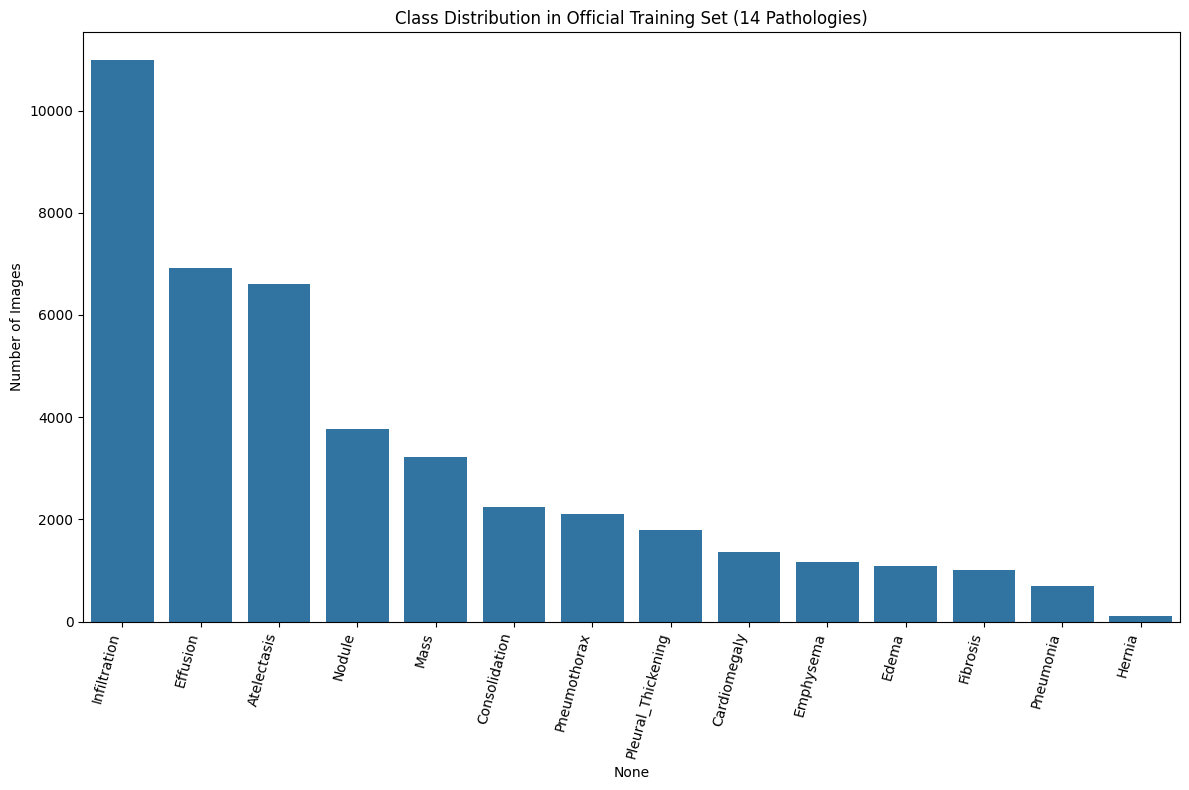

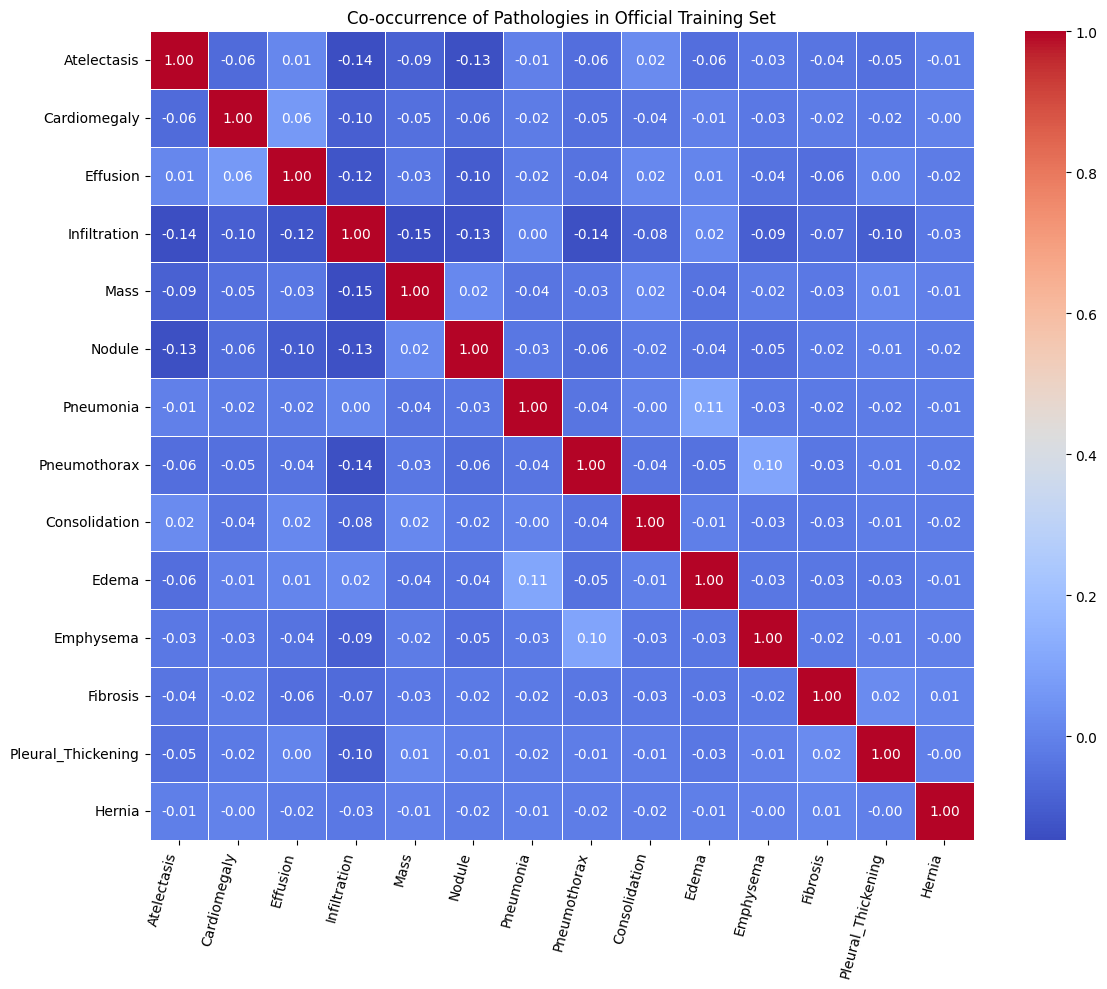

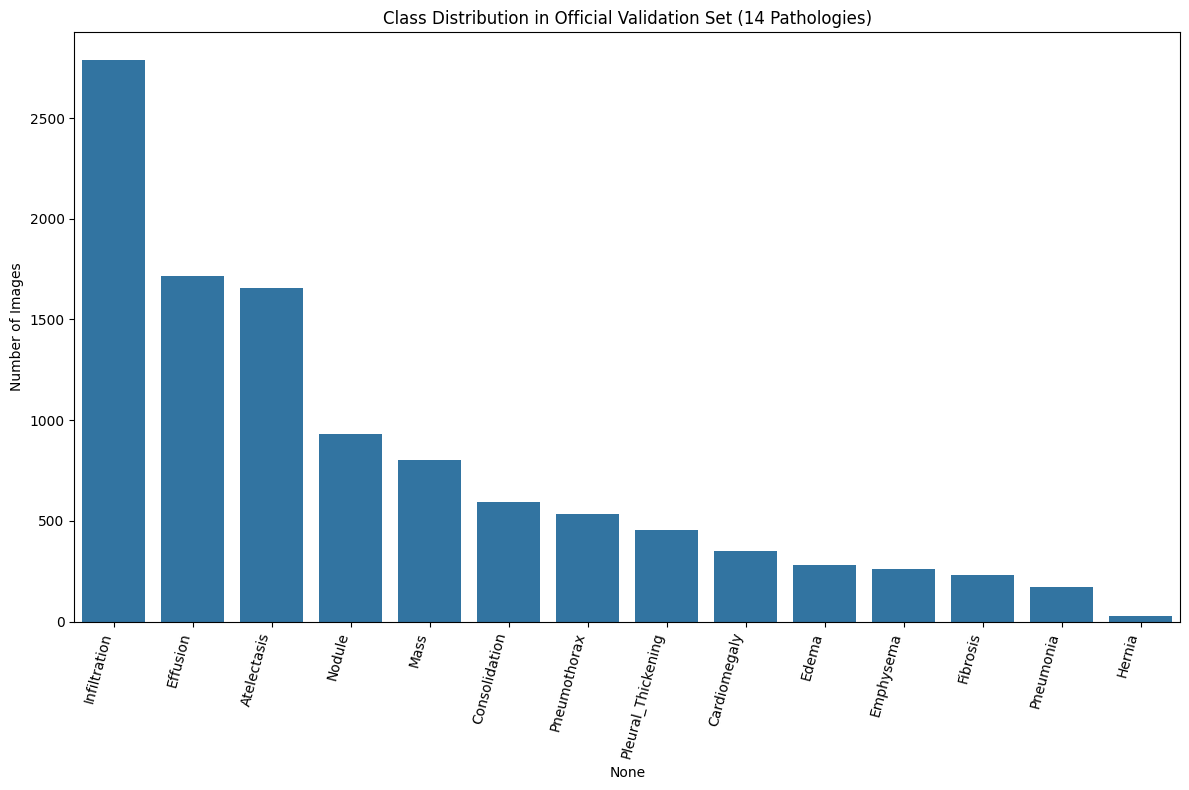

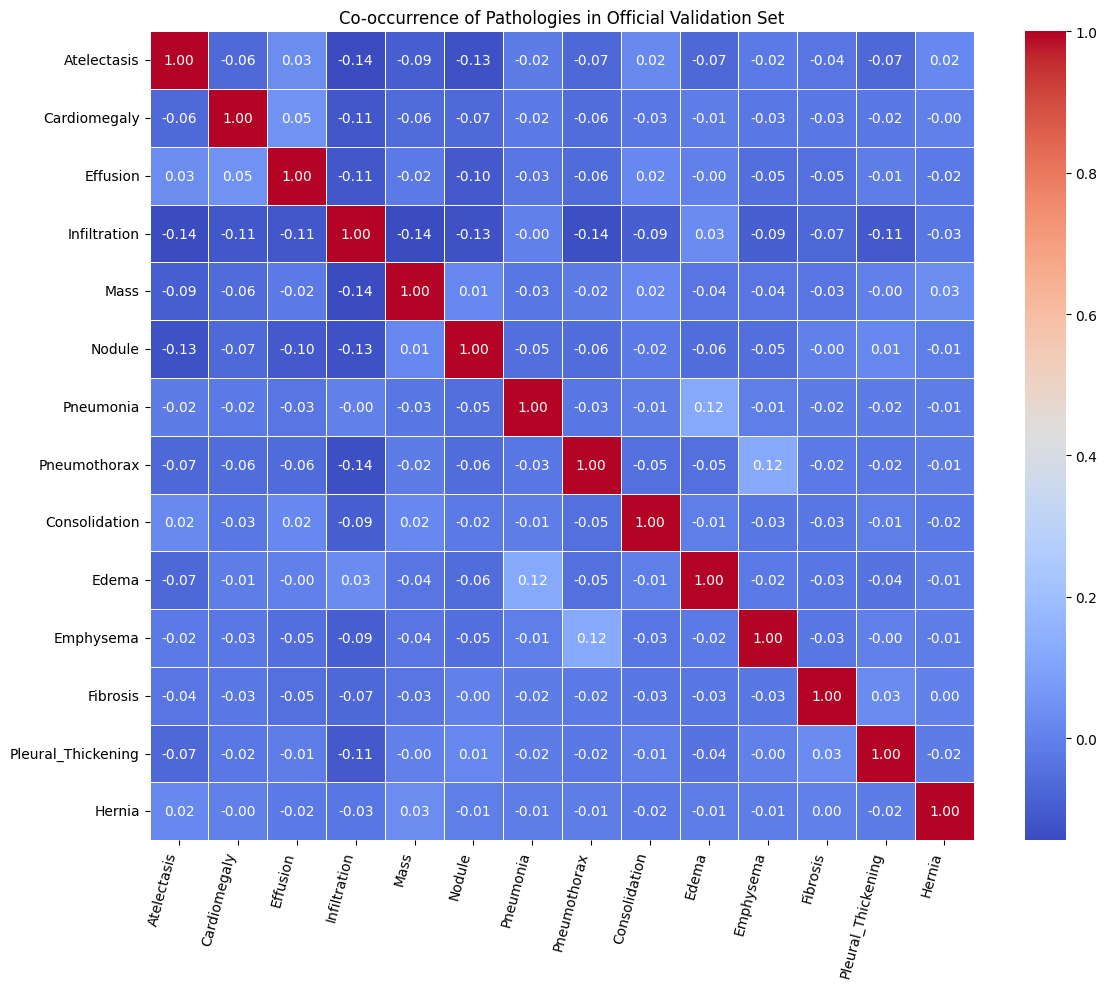

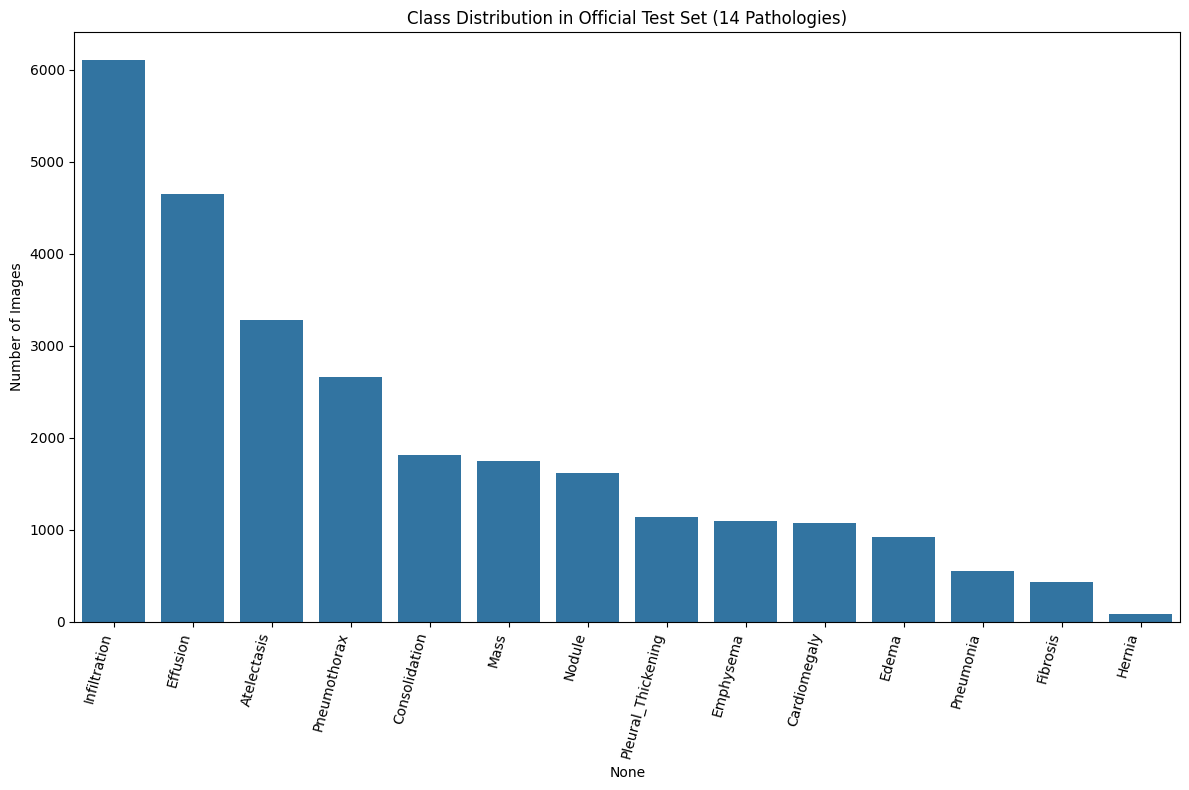

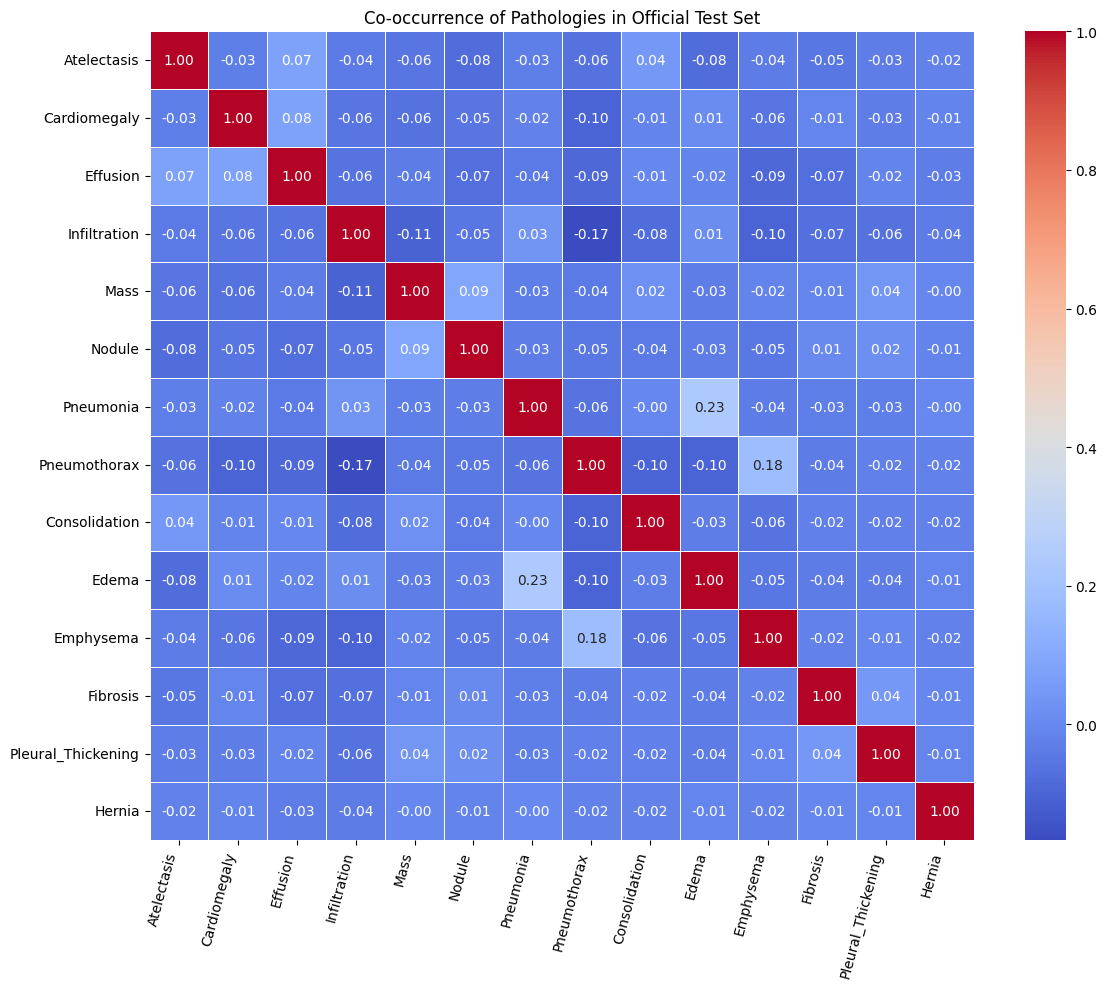


--- 3. Building Model ---
Calculated positive class weights (capped at 25.0): [np.float64(3.3506198971877836), np.float64(20.236162361623617), np.float64(3.1582369942196533), np.float64(1.6201966854853396), np.float64(7.925248138957817), np.float64(6.640732873074881), 25.0, np.float64(12.708909004287756), np.float64(11.77753108348135), 25.0, np.float64(23.784668389319553), 25.0, np.float64(15.120448179271708), 25.0]
Building model with backbone: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)        │ (None, 224, 224, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ Conv1 (Conv2D)                    │ (None, 112, 112, 32)         │               864 │ input_layer_1[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bn_Conv1 (BatchNormalization)     │ (None, 112, 112, 32)         │               128 │ Conv1[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ Conv1_relu (ReLU)                 │ (None, 112, 112, 32)         │                 0 │ bn_Conv1[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_depthwise           │ (None, 112, 112, 32)         │               288 │ Conv1_relu[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_depthwise_BN        │ (None, 112, 112, 32)         │               128 │ expanded_conv_depthwise[0]
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_depthwise_relu      │ (None, 112, 112, 32)         │                 0 │ expanded_conv_depthwise_BN
│ (ReLU)                            │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_project (Conv2D)    │ (None, 112, 112, 16)         │               512 │ expanded_conv_depthwise_re
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_project_BN          │ (None, 112, 112, 16)         │                64 │ expanded_conv_project[0][0
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_expand (Conv2D)           │ (None, 112, 112, 96)         │             1,536 │ expanded_conv_project_BN[0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_expand_BN                 │ (None, 112, 112, 96)         │               384 │ block_1_expand[0][0]      
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_expand_relu (ReLU)        │ (None, 112, 112, 96)         │                 0 │ block_1_expand_BN[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_pad (ZeroPadding2D)       │ (None, 113, 113, 96)         │                 0 │ block_1_expand_relu[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_depthwise                 │ (None, 56, 56, 96)

 Total params: 2,275,918 (8.68 MB)

 Trainable params: 17,934 (70.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None

--- 4. Initial Training ---
Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - auc_pr: 0.1458 - auc_roc: 0.5969 - binary_accuracy: 0.5882 - loss: 1.2045
Epoch 1: val_auc_roc improved from -inf to 0.66433, saving model to best_initial_MobileNetV2.weights.h5
900/900 ━━━━━━━━━━━━━━━━━━━━ 9343s 10s/step - auc_pr: 0.1459 - auc_roc: 0.5969 - binary_accuracy: 0.5882 - loss: 1.2044 - val_auc_pr: 0.1736 - val_auc_roc: 0.6643 - val_binary_accuracy: 0.6501 - val_loss: 1.2049 - learning_rate: 0.0010
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - auc_pr: 0.1764 - auc_roc: 0.6688 - binary_accuracy: 0.6248 - loss: 1.1428
Epoch 2: val_auc_roc improved from 0.66433 to 0.67114, saving model to best_initial_MobileNetV2.weights.h5
900/900 ━━━━━━━━━━━━━━━━━━━━ 933s 987ms/step - auc_pr: 0.1764 - auc_roc: 0.6688 - binary_accuracy: 0.6248 - loss: 1.1428 - val_auc_pr: 0.1787 - val_auc_roc: 0.6711 - val_binary_accuracy: 0.7054 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 3/20
900/900 ━━━━━━

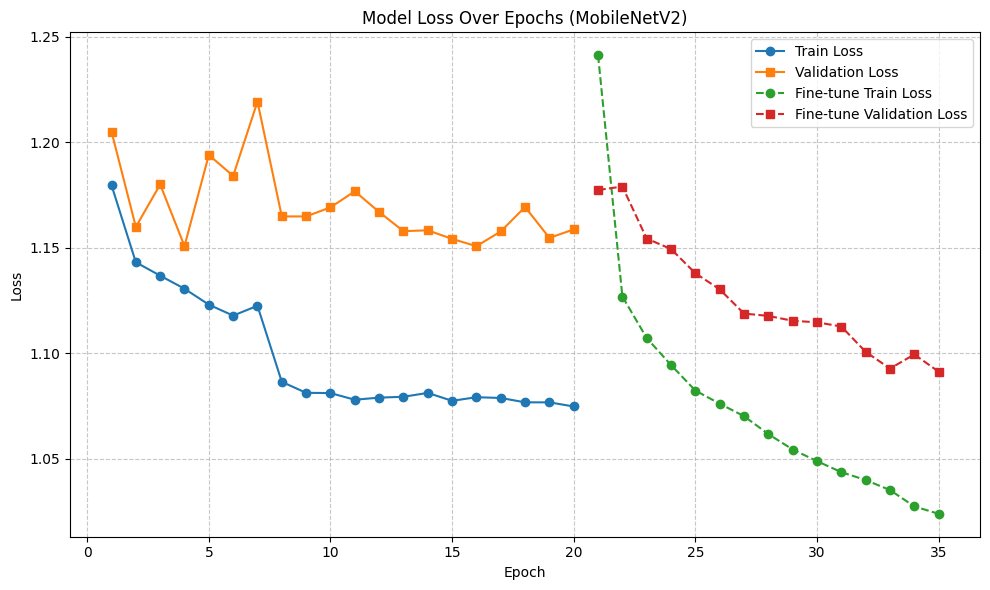

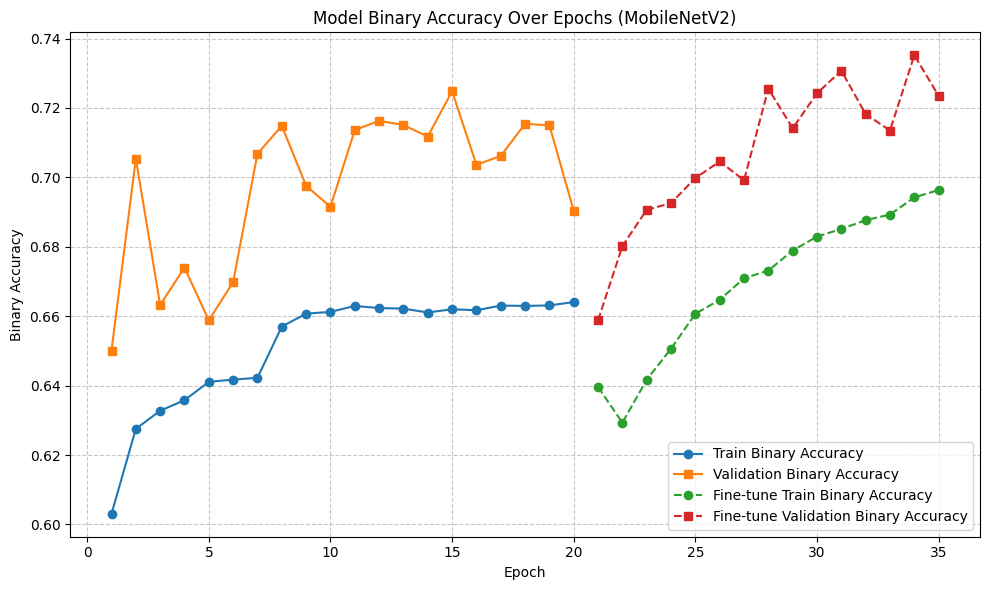

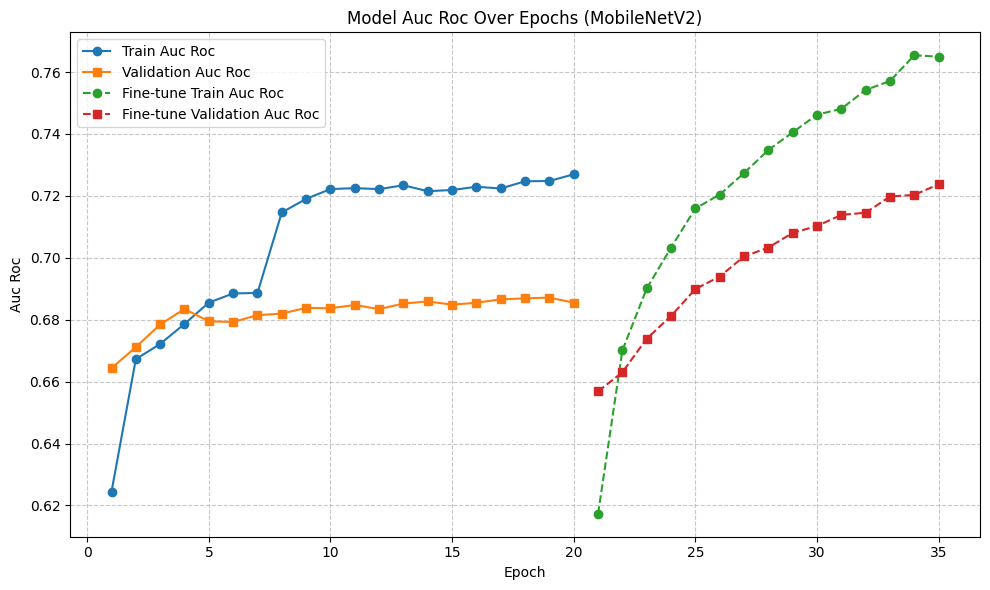

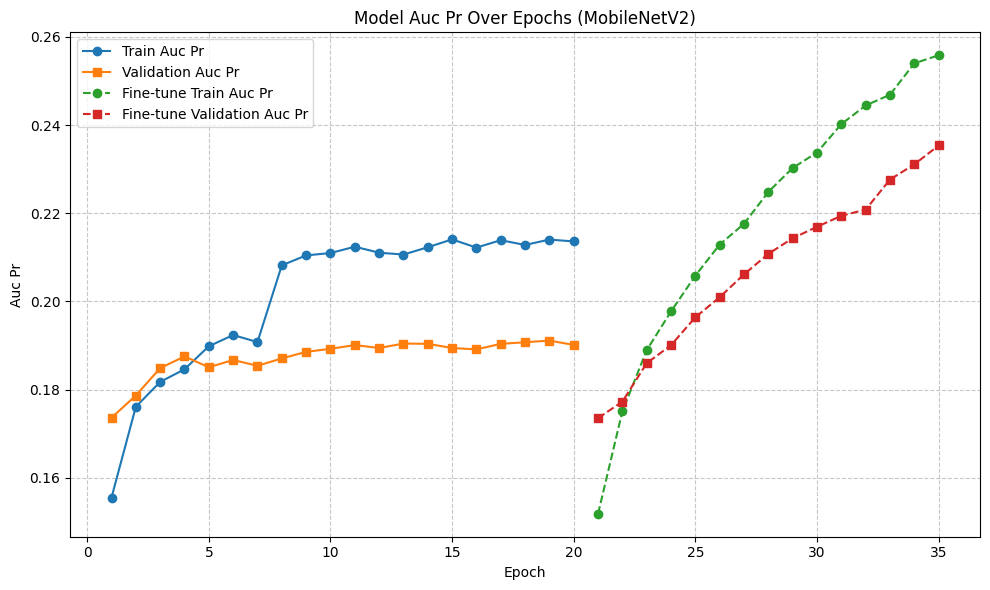


--- 7. Loading Best Weights & Saving Final Model ---
Loading best fine-tuned weights for evaluation & saving: best_finetuned_MobileNetV2.weights.h5

--- Saving Final Model (MobileNetV2) ---
Model saved in Keras format: /content/drive/MyDrive/NIH_Chest_Xray/saved_models_final/final_model_finetuned_MobileNetV2_20250520_055228.keras
Error saving model in TensorFlow SavedModel format: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf
Saved artifact at '/tmp/tmpvxwube5z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  136681698967376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136680048838608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136680048836688: Te

ValueError: Failed to find a suitable Grad-CAM target layer for MobileNetV2. Manual specification might be needed or check model structure.

<Figure size 2000x700 with 0 Axes>

In [ ]:
def main():
    # --- Load Data (including BBoxes) ---
    print("\n--- 1. Loading Data ---")
    full_dataset_df, bbox_df = load_data()
    analyze_class_distribution(full_dataset_df, "Full Processed Dataset")
    visualize_sample_images(full_dataset_df, num_samples=1)

    # --- Preprocessing & Splitting ---
    print("\n--- 2. Preprocessing & Official Split ---")
    train_gen, valid_gen, test_gen = None, None, None
    train_set_df, valid_set_df, test_set_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    train_gen, valid_gen, test_gen, train_set_df, valid_set_df, test_set_df = preprocess_data(full_dataset_df, bbox_df)

    # --- Model Build & Compile ---
    print("\n--- 3. Building Model ---")
    pos_weights = calculate_positive_class_weights(train_set_df[SELECTED_CONDITIONS])
    weighted_loss_fn = get_weighted_binary_crossentropy(pos_weights)
    model, base_model_instance = build_model(IMG_SIZE, len(SELECTED_CONDITIONS), weighted_loss_fn, backbone_name=SELECTED_BACKBONE)
    print(model.summary(line_length=120))

    # --- Training Phases ---
    print("\n--- 4. Initial Training ---")
    history_initial = None
    if not train_set_df.empty:
        history_initial = train_model(model, train_gen, valid_gen, len(train_set_df), len(valid_set_df), epochs=20)
    else: print("Skipping initial training.")

    print("\n--- 5. Fine-tuning ---")
    history_finetuned = None
    best_initial_weights = 'best_model_initial.weights.h5'
    if history_initial and not train_set_df.empty:
        if os.path.exists(best_initial_weights):
            print(f"Loading best weights from initial phase: {best_initial_weights}")
            model.load_weights(best_initial_weights)
        history_finetuned = fine_tune_model(model, base_model_instance, train_gen, valid_gen, len(train_set_df), len(valid_set_df), weighted_loss_fn, epochs=15)

    # --- Plot History ---
    if history_initial:
        print("\n--- 6. Plotting Training Metrics ---")
        plot_training_history(history_initial, history_finetuned)

    # --- Evaluation (Classification & Localization) ---
    print("\n--- 7. Evaluating Model on Official Test Set ---")
    model_loaded_for_eval = False
    best_finetuned_weights = 'best_model_finetuned.weights.h5'
    if os.path.exists(best_finetuned_weights):
        model.load_weights(best_finetuned_weights); model_loaded_for_eval = True
    elif os.path.exists(best_initial_weights):
        model.load_weights(best_initial_weights); model_loaded_for_eval = True
    elif history_initial or history_finetuned:
         print("Evaluating with weights currently in memory (best checkpoint may not exist)."); model_loaded_for_eval = True

    if model_loaded_for_eval and not test_set_df.empty:
        evaluate_model(model, test_gen, test_set_df)
        evaluate_localization(model, test_set_df, bbox_df, SELECTED_CONDITIONS, heatmap_threshold=0.2, iou_threshold=0.1) # Tune thresholds

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')